Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

In [1]:
# Ksenia
# 28/01/24
# v.01


1. Получить данные 

In [2]:
import mglearn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

from sklearn.datasets import load_digits

# Загрузка данных 
digits = load_digits()
X = digits.data
y = digits.target
print(digits.data.shape)


(1797, 64)


<Figure size 640x480 with 0 Axes>

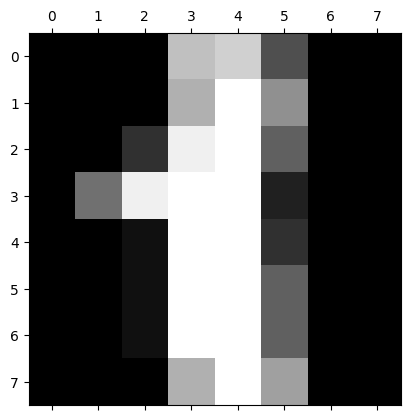

In [3]:
plt.gray()
plt.matshow(digits.images[1])
plt.show()

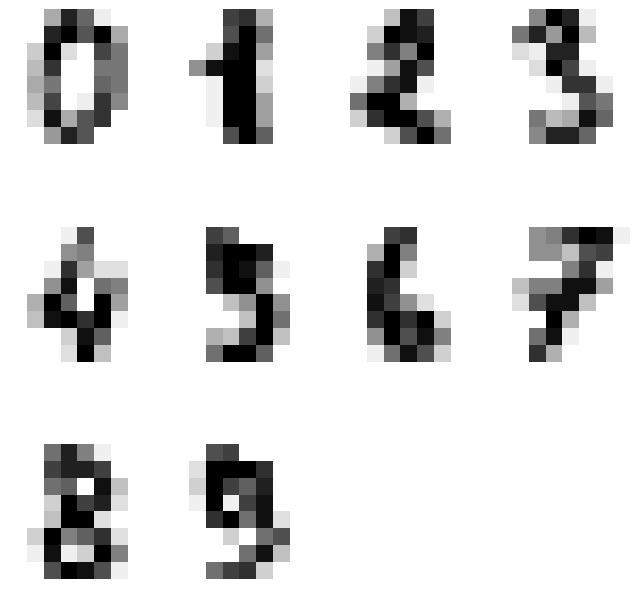

In [4]:
# Визуализация первых десяти картинок
plt.figure(figsize=(8, 8))
for i in range(10):
    plt.subplot(3, 4, i + 1)
    plt.imshow(16 - X[i].reshape(8, 8), cmap='gray', interpolation='nearest')
    plt.axis('off')

plt.show()

2. Кластеризация и оценка качества


In [5]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [6]:
# Иерархическая кластеризация
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(X)

In [7]:
agg_labels

array([7, 9, 4, ..., 4, 1, 4], dtype=int64)

In [8]:
# K-средних
kmeans = KMeans(n_clusters=10, n_init=100)  # Увеличим число запусков
kmeans_labels = kmeans.fit_predict(X)

In [9]:
kmeans_labels

array([4, 8, 8, ..., 8, 3, 3])

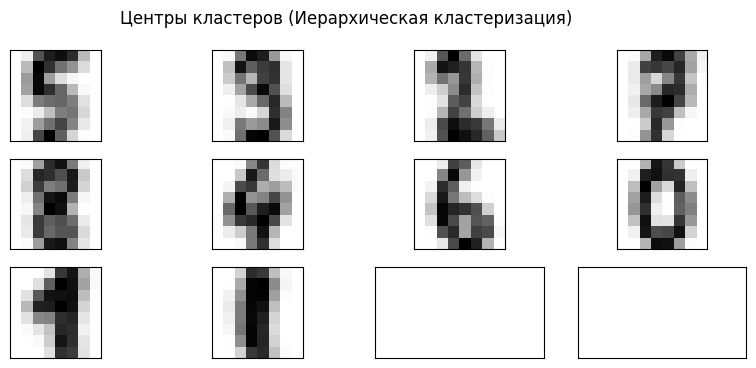

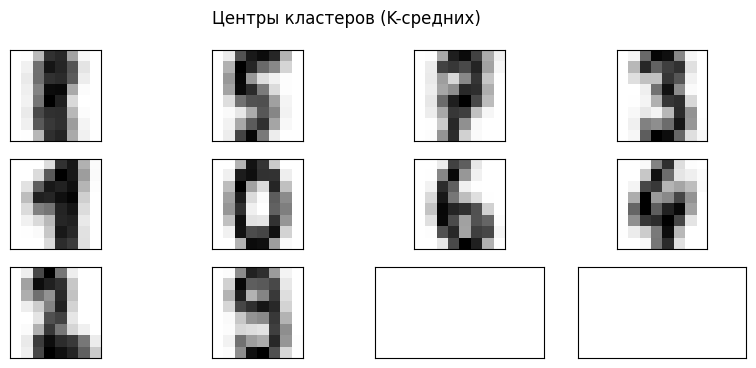

In [10]:

def visualize_centers(centers, title):
    # Визуализация центров кластеров
    fig, axes = plt.subplots(3, 4, figsize=(10, 4),
                             subplot_kw={'xticks': (), 'yticks': ()})
    plt.suptitle(title)

    for ax, center in zip(axes.ravel(), centers):
        ax.imshow(center.reshape(8, 8), cmap=plt.cm.gray_r, interpolation="nearest")
    
    plt.show()

# Иерархическая кластеризация
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(X)
agg_centers = np.array([np.mean(X[agg_labels == i], axis=0) for i in range(10)])
visualize_centers(agg_centers, "Центры кластеров (Иерархическая кластеризация)")

# K-средних
kmeans = KMeans(n_clusters=10, n_init=100, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_centers = kmeans.cluster_centers_
visualize_centers(kmeans_centers, "Центры кластеров (K-средних)")


In [27]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Для K-средних
kmeans_labels_mapped = np.zeros_like(kmeans_labels)
for i in range(10):
   mask = (kmeans_labels == i)
   kmeans_labels_mapped[mask] = mode(digits.target[mask])[0]

accuracy_kmeans = accuracy_score(digits.target, kmeans_labels_mapped)
print("Accuracy for K-means clustering:", accuracy_kmeans)

# Для иерархической кластеризации
hierarchical_labels_mapped = np.zeros_like(hierarchical_labels)
for i in range(10):
   mask = (hierarchical_labels == i)
   hierarchical_labels_mapped[mask] = mode(digits.target[mask])[0]

accuracy_hierarchical = accuracy_score(digits.target, hierarchical_labels_mapped)
print("Accuracy for Hierarchical clustering:", accuracy_hierarchical)

Accuracy for K-means clustering: 0.7935447968836951
Accuracy for Hierarchical clustering: 0.9443516972732332


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled=scaler.fit_transform(X)

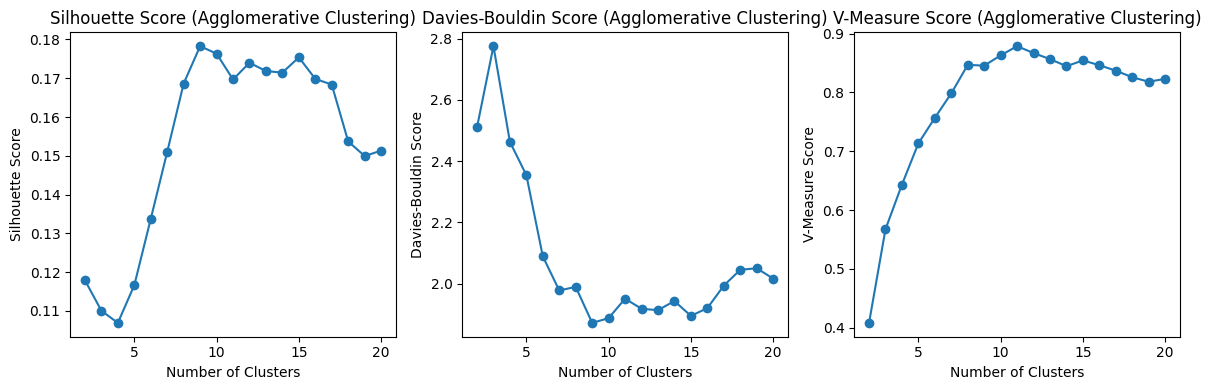

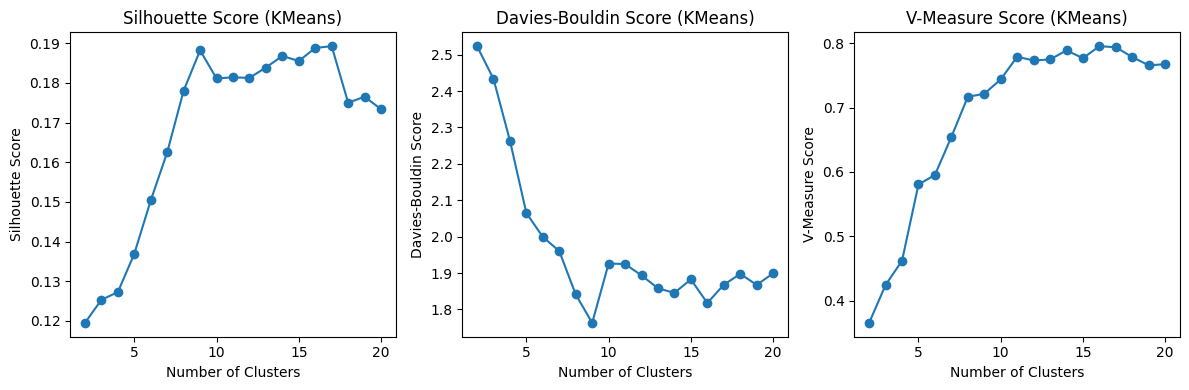

In [16]:
# Вычисление основных метрик: silhouette_score, davies_bouldin_score,v_measure_score
from sklearn.metrics import silhouette_score, v_measure_score, davies_bouldin_score, homogeneity_completeness_v_measure

# Список значений K
k_values = range(2, 21)

# Инициализация списков для метрик
silhouette_scores_agg = []
davies_bouldin_scores_agg = []
v_measure_scores_agg = []

silhouette_scores_kmeans = []
davies_bouldin_scores_kmeans = []
v_measure_scores_kmeans = []

# Итерация по разным значениям K
for k in k_values:
    # Иерархическая кластеризация
    agg_clustering = AgglomerativeClustering(n_clusters=k)
    agg_labels = agg_clustering.fit_predict(X_scaled)
    
    silhouette_scores_agg.append(silhouette_score(X_scaled, agg_labels))
    davies_bouldin_scores_agg.append(davies_bouldin_score(X_scaled, agg_labels))
    v_measure_scores_agg.append(v_measure_score(y, agg_labels))  # y - фактические метки
    
    # KMeans
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    
    silhouette_scores_kmeans.append(silhouette_score(X_scaled, kmeans_labels))
    davies_bouldin_scores_kmeans.append(davies_bouldin_score(X_scaled, kmeans_labels))
    v_measure_scores_kmeans.append(v_measure_score(y, kmeans_labels))  # y - фактические метки

# Визуализация метрик для иерархической кластеризации
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(k_values, silhouette_scores_agg, marker='o')
plt.title('Silhouette Score (Agglomerative Clustering)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(k_values, davies_bouldin_scores_agg, marker='o')
plt.title('Davies-Bouldin Score (Agglomerative Clustering)')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')

plt.subplot(1, 3, 3)
plt.plot(k_values, v_measure_scores_agg, marker='o')
plt.title('V-Measure Score (Agglomerative Clustering)')
plt.xlabel('Number of Clusters')
plt.ylabel('V-Measure Score')

plt.tight_layout()
plt.show()

# Визуализация метрик для KMeans
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(k_values, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Score (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.subplot(1, 3, 2)
plt.plot(k_values, davies_bouldin_scores_kmeans, marker='o')
plt.title('Davies-Bouldin Score (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Score')

plt.subplot(1, 3, 3)
plt.plot(k_values, v_measure_scores_kmeans, marker='o')
plt.title('V-Measure Score (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('V-Measure Score')

plt.tight_layout()
plt.show()


In [17]:
# Найдем, при каком числе кластеров достигается максимум V-меры
best_k_agg = k_values[np.argmax(v_measure_scores_agg)]
best_k_kmeans = k_values[np.argmax(v_measure_scores_kmeans)]

print("Лучшее число кластеров для иерархической кластеризации:", best_k_agg)
print("Лучшее число кластеров для KMeans:", best_k_kmeans)

Лучшее число кластеров для иерархической кластеризации: 11
Лучшее число кластеров для KMeans: 16


In [18]:
# Иерархическая кластеризация
agg_clustering = AgglomerativeClustering(n_clusters=11)
agg_labels = agg_clustering.fit_predict(X_scaled)

# K-means кластеризация
kmeans = KMeans(n_clusters=16, n_init=100, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Силуэт и V-мера для иерархической кластеризации
silhouette_scores_agg = silhouette_score(X_scaled, agg_labels)
v_measure_scores_agg = v_measure_score(y, agg_labels)

# Силуэт и V-мера для K-means кластеризации
silhouette_score_kmeans = silhouette_score(X_scaled, kmeans_labels)
v_measure_score_kmeans = v_measure_score(y, kmeans_labels)

# Вывод результатов
print("Hierarchical Clustering:")
print("Silhouette Score:", silhouette_scores_agg)
print("V-Measure Score:", v_measure_scores_agg)
print("K-means Clustering:")
print("Silhouette Score:", silhouette_score_kmeans)
print("V-Measure Score:", v_measure_score_kmeans)

Hierarchical Clustering:
Silhouette Score: 0.16968289005049048
V-Measure Score: 0.8786439947986164
K-means Clustering:
Silhouette Score: 0.1887924667331523
V-Measure Score: 0.795290324029604


3. Снижение размерности признакового пространства

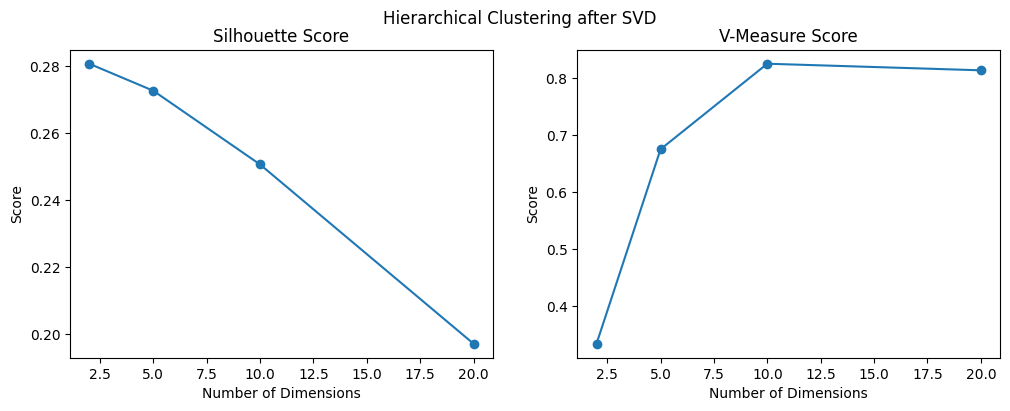

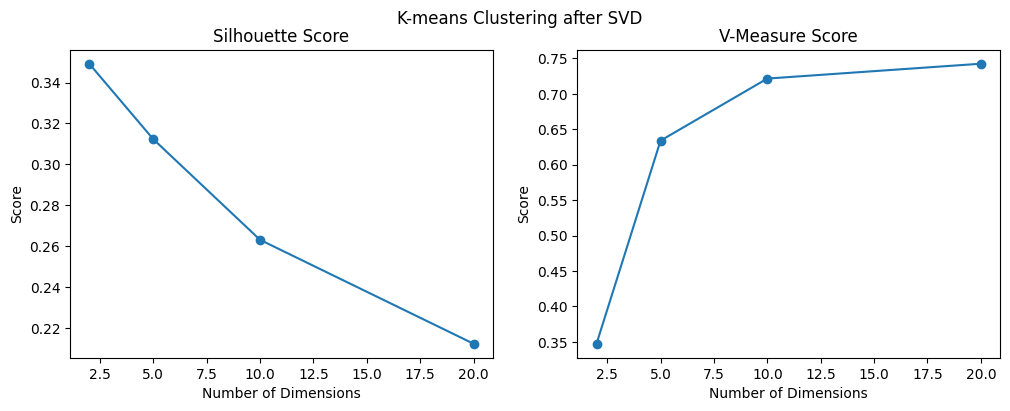

In [19]:
from sklearn.decomposition import TruncatedSVD

# Функция для визуализации графика силуэта и V-меры
def plot_scores(dimensions, silhouette_scores, v_measure_scores, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(dimensions, silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Number of Dimensions')
    plt.ylabel('Score')

    plt.subplot(1, 2, 2)
    plt.plot(dimensions, v_measure_scores, marker='o')
    plt.title('V-Measure Score')
    plt.xlabel('Number of Dimensions')
    plt.ylabel('Score')

    plt.suptitle(title)
    plt.show()


# Число кластеров
n_clusters = 10

# Размерности для сингулярного разложения (количество новых признаков, которые будут использованы после сингулярного разложения данных)
dimensions = [2, 5, 10, 20]

# Списки для хранения результатов
silhouette_scores_svd = []
v_measure_scores_svd = []

# Выполнение кластеризации для различных размерностей
for d in dimensions:
    # Сингулярное разложение
    svd = TruncatedSVD(n_components=d, random_state=42)
    X_svd = svd.fit_transform(X)

    # Иерархическая кластеризация
    agg = AgglomerativeClustering(n_clusters=n_clusters)
    agg_labels = agg.fit_predict(X_svd)

    silhouette_scores_svd.append(silhouette_score(X_svd, agg_labels))
    v_measure_scores_svd.append(v_measure_score(y, agg_labels))

# Визуализация результатов
plot_scores(dimensions, silhouette_scores_svd, v_measure_scores_svd, 'Hierarchical Clustering after SVD')

# Сброс списков для K-means
silhouette_scores_svd = []
v_measure_scores_svd = []

# Выполнение кластеризации для различных размерностей
for d in dimensions:
    # Сингулярное разложение
    svd = TruncatedSVD(n_components=d, random_state=42)
    X_svd = svd.fit_transform(X)

    # K-means
    kmeans = KMeans(n_clusters=n_clusters, n_init=100, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_svd)

    silhouette_scores_svd.append(silhouette_score(X_svd, kmeans_labels))
    v_measure_scores_svd.append(v_measure_score(y, kmeans_labels))

# Визуализация результатов
plot_scores(dimensions, silhouette_scores_svd, v_measure_scores_svd, 'K-means Clustering after SVD')


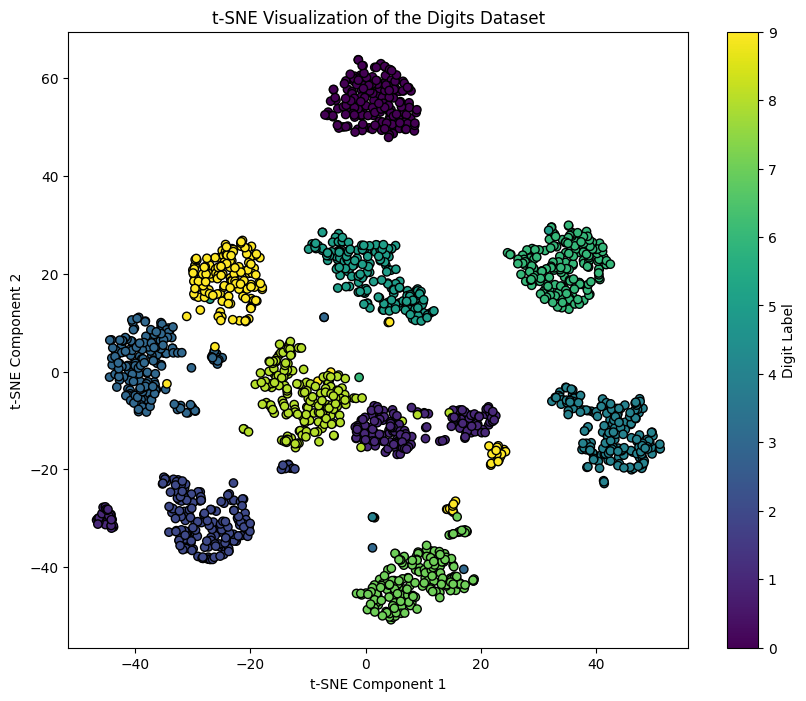

In [20]:

from sklearn.manifold import TSNE

# Создаем объект t-SNE с двумя компонентами
tsne = TSNE(n_components=2, random_state=42)

# Выполняем t-SNE преобразование
X_tsne = tsne.fit_transform(X)

# Визуализация
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', edgecolor='k')
plt.title('t-SNE Visualization of the Digits Dataset')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Digit Label')
plt.show()


In [21]:

# Иерархическая кластеризация
hierarchical_clustering = AgglomerativeClustering(n_clusters=10)
hierarchical_labels = hierarchical_clustering.fit_predict(X_tsne)

# K-means кластеризация
kmeans_clustering = KMeans(n_clusters=10, random_state=42)
kmeans_labels_tsne = kmeans_clustering.fit_predict(X_tsne)

# Силуэт и V-мера для иерархической кластеризации
silhouette_score_hierarchical = silhouette_score(X_tsne, hierarchical_labels)
v_measure_score_hierarchical = v_measure_score(y, hierarchical_labels)

# Силуэт и V-мера для K-means кластеризации
silhouette_score_kmeans_tsne = silhouette_score(X_tsne, kmeans_labels_tsne)
v_measure_score_kmeans_tsne = v_measure_score(y, kmeans_labels_tsne)

# Вывод результатов
print("Hierarchical Clustering:")
print("Silhouette Score:", silhouette_score_hierarchical)
print("V-Measure Score:", v_measure_score_hierarchical)
print("\nK-means Clustering (t-SNE transformed data):")
print("Silhouette Score:", silhouette_score_kmeans_tsne)
print("V-Measure Score:", v_measure_score_kmeans_tsne)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Hierarchical Clustering:
Silhouette Score: 0.63888395
V-Measure Score: 0.911056555346593

K-means Clustering (t-SNE transformed data):
Silhouette Score: 0.6419638
V-Measure Score: 0.9116334462095017


In [22]:
# Найдем, при каком числе кластеров достигается максимум V-меры
best_k_hierarchical = k_values[np.argmax(v_measure_score_hierarchical)]
best_k_kmeans_tsne = k_values[np.argmax(v_measure_score_kmeans_tsne)]

print("Лучшее число кластеров для иерархической кластеризации:", best_k_hierarchical)
print("Лучшее число кластеров для KMeans:", best_k_kmeans_tsne)

Лучшее число кластеров для иерархической кластеризации: 2
Лучшее число кластеров для KMeans: 2


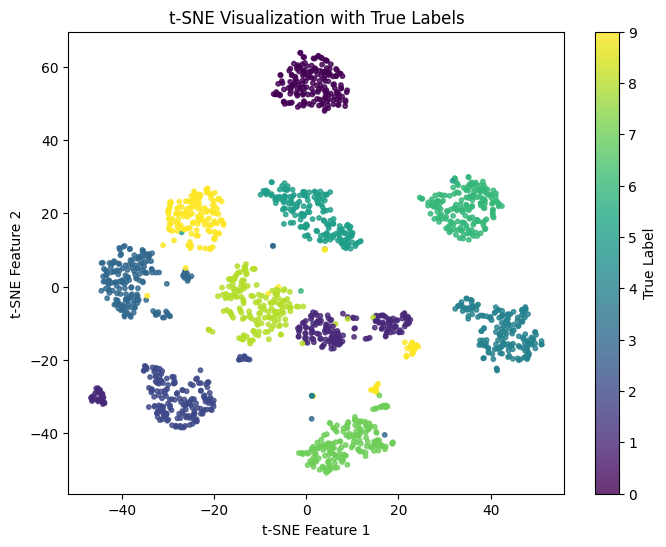

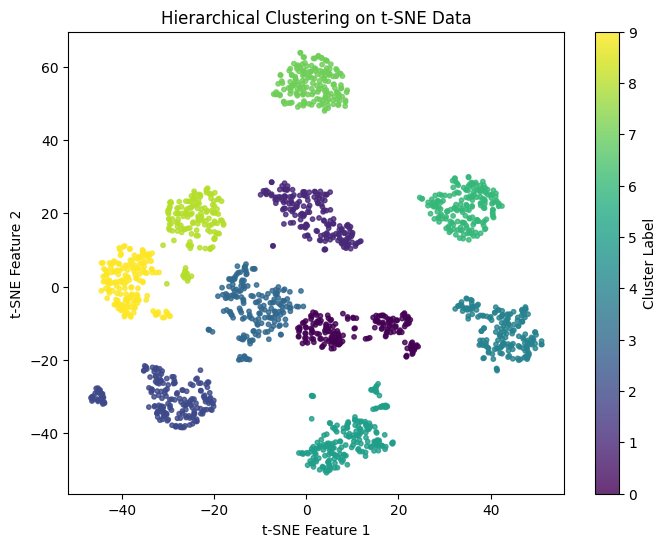

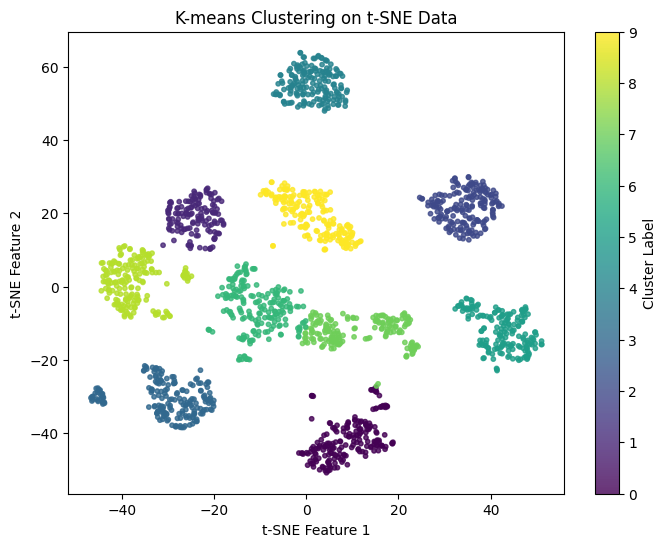

In [23]:
# Визуализация данных после t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='viridis', s=10, alpha=0.8)
plt.title('t-SNE Visualization with True Labels')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='True Label')
plt.show()

# Визуализация кластеров после иерархической кластеризации
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=hierarchical_labels, cmap='viridis', s=10, alpha=0.8)
plt.title('Hierarchical Clustering on t-SNE Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

# Визуализация кластеров после K-means кластеризации
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels_tsne, cmap='viridis', s=10, alpha=0.8)
plt.title('K-means Clustering on t-SNE Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()


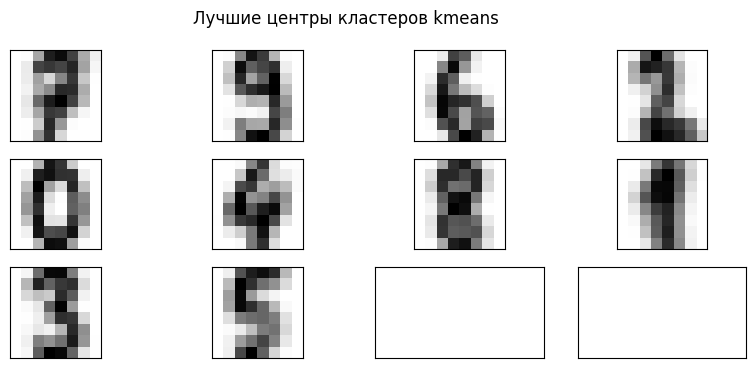

In [24]:
# Для kmeans
best_labels = kmeans_labels_tsne  # Замените на свой выбор

# Визуализация центров кластеров
best_centers_kmeans = np.array([np.mean(X[best_labels == i], axis=0) for i in range(10)])
visualize_centers(best_centers_kmeans, "Лучшие центры кластеров kmeans")


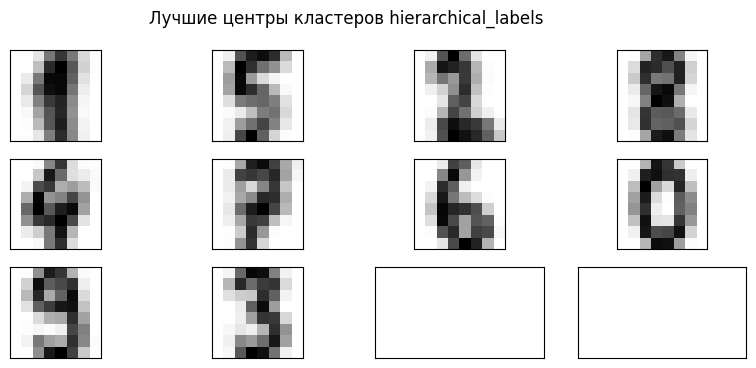

In [25]:
# Для hierarchical_labels
best_labels = hierarchical_labels  # Замените на свой выбор

# Визуализация центров кластеров
best_centers_hierarchical = np.array([np.mean(X[best_labels == i], axis=0) for i in range(10)])
visualize_centers(best_centers_hierarchical, "Лучшие центры кластеров hierarchical_labels")

In [26]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score

# Для K-средних
kmeans_labels_mapped = np.zeros_like(kmeans_labels)
for i in range(10):
   mask = (kmeans_labels == i)
   kmeans_labels_mapped[mask] = mode(digits.target[mask])[0]

accuracy_kmeans = accuracy_score(digits.target, kmeans_labels_mapped)
print("Accuracy for K-means clustering:", accuracy_kmeans)

# Для иерархической кластеризации
hierarchical_labels_mapped = np.zeros_like(hierarchical_labels)
for i in range(10):
   mask = (hierarchical_labels == i)
   hierarchical_labels_mapped[mask] = mode(digits.target[mask])[0]

accuracy_hierarchical = accuracy_score(digits.target, hierarchical_labels_mapped)
print("Accuracy for Hierarchical clustering:", accuracy_hierarchical)


Accuracy for K-means clustering: 0.7935447968836951
Accuracy for Hierarchical clustering: 0.9443516972732332


Выводы: 

После снижения размерности:

1) В Иерархической кластеризации: 
Максимальное значение silhouette_score (0,28) достигается при количестве признаков = 2, что говорит о наилучшей отделимости объектов внутри кластеров и хорошем разделении между кластерами при двух признаках.
Значения silhouette_score уменьшаются с увеличением числа признаков, что может свидетельствовать о потере структуры данных или усложнении задачи кластеризации при увеличении размерности.
Значения v_measure_score увеличиваются с увеличением числа признаков, достигая максимума при количестве признаков = 11. Это может указывать на лучшую однородность и полноту кластеров при этой размерности.

В K-means кластеризации:
Максимальное значение silhouette_score(0,35) также достигается при количестве признаков = 2, что подтверждает лучшую отделимость кластеров при двух признаках.
Значения silhouette_score уменьшаются с увеличением числа признаков, что указывает на потенциальное усложнение задачи кластеризации.
Значения v_measure_score ведут себя схожим образом как в иерархической кластеризации, увеличиваясь и достигая максимума при количестве признаков = 20.

Для обоих методов наилучшие результаты по silhouette_score достигаются при малом числе признаков (2).
Значения v_measure_score более чувствительны к увеличению числа признаков, но в Иерархической кластеризации достигают максимума при числе признаков= 11.

В сравнении с исходными данными показатель silhouette_score увеличился, что связано с более четким разделением границ кластеров после уменьшения размерности.

2) После применения t-SNE произошли следующие изменения в метриках кластеризации:

Hierarchical Clustering:

Silhouette Score: Улучшился с 0.1697 до 0.6389.
V-Measure Score: Улучшился с 0.8786 до 0.9111.
K-means Clustering (t-SNE transformed data):

Silhouette Score: Улучшился с 0.1888 до 0.6420.
V-Measure Score: Улучшился с 0.7953 до 0.9116.

Silhouette Score: После применения t-SNE значение силуэта увеличилось для обеих моделей кластеризации, что указывает на более четкие и раздельные кластеры в новом признаковом пространстве.

V-Measure Score: Показатель V-меры также значительно улучшился после t-SNE для обеих моделей. Это может свидетельствовать о более точном соответствии кластеров исходным меткам данных.

Количество кластеров: Лучшее число кластеров изменилось с 11 и 16 до 2. Это может быть связано с тем, что новое признаковое пространство, созданное t-SNE, может требовать меньшего числа кластеров для учета дополнительной структуры данных.

----> Применение t-SNE позволило получить более высокие значения силуэта и V-меры для обеих моделей, что говорит о более эффективной кластеризации в новом пространстве признаков.

----> Расчет accuracy_score для меток кластеров после K-средних и иерархической кластеризации также подтверждает, что иерархическая кластеризация предоставляет более точное разбиение данных
